In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    from transformers import AutoModelForSequenceClassification, AutoTokenizer,AutoModelForTokenClassification,pipeline 
except:
    !pip3 install transformers
    from transformers import AutoModelForSequenceClassification, AutoTokenizer,AutoModelForTokenClassification, pipeline 

import torch
from torch.utils.data import IterableDataset, DataLoader

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 52.9 MB/s 
     |████████████████████████████████| 61 kB 121 kB/s 
     |████████████████████████████████| 596 kB 49.7 MB/s 
     |████████████████████████████████| 895 kB 33.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Task 3: Sentiment Analysis

## Context

In this notebook, we'll leverage Bert sentiment anaylsis to induce the sentiment about bitcoin in our data.<br>
As a gentle reminder, Bert's model takes two sentences and gives a score about how much they're close.<br>
We've already done it in a basic naive way previously in task 1 using "positive" and "negative" words as a metric, but it was not accurate and allowed very noisy values. <br>
To deal with this problem, we apply Bert's model on other more relevant words in the finance domain and average among these.

##Analysis

In [ ]:
df_bitcoin = pd.read_csv('/content/drive/MyDrive/Shared_ADA/M3/data/bitcoin_data.csv')
df_bitcoin.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-10-04-032770,Litecoin Shows There Is a Simple Fix for Spam ...,Charlie Lee,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",2015-10-04 18:48:44,1,"[['Charlie Lee', '0.9254'], ['None', '0.0746']]",['http://cointelegraph.com/news/115374/the-ong...,E
1,2015-09-15-114302,We believe that you deserve to reap the benefi...,Vishal Gupta,['Q57623555'],2015-09-15 20:32:32,1,"[['Vishal Gupta', '0.5501'], ['None', '0.2781'...",['http://benzinga.com/news/15/09/5835310/bitco...,E
2,2015-02-06-003563,AmEx needs to get into Bitcoin or one of the o...,Porter Bibb,['Q7231593'],2015-02-06 21:39:00,2,"[['Porter Bibb', '0.8712'], ['None', '0.1288']]",['http://us.rd.yahoo.com/finance/external/inve...,E
3,2015-06-22-017667,If each bitcoin has a history and people know ...,Greg Maxwell,['Q46997142'],2015-06-22 14:45:56,1,"[['Greg Maxwell', '0.966'], ['None', '0.034']]",['http://www.newsbtc.com/2015/06/22/how-blocks...,E
4,2015-10-07-012201,Bitcoin in its current incarnation is slow in ...,Ann Cairns,['Q28870363'],2015-10-07 17:02:57,1,"[['Ann Cairns', '0.8585'], ['None', '0.1415']]",['http://cointelegraph.com/news/115390/masterc...,E


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli',output_attentions=True).to(device)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

In [ ]:
# Apply Bert model
def predict_proba(quotations, hypothesis, batch_size=4):
  """
    quotations: list of string
    hypothesis: string : hypothesis we want to test 
    batch_size: int
  """
  scores = []
  for i in tqdm(range(0, len(quotations), batch_size)):
      # Get subset of quotations
      quotation_batch = quotations[i:i+batch_size]

      # Tokenize input to get tensor input
      x = tokenizer(quotation_batch, [hypothesis]*len(quotation_batch) ,max_length = 512, padding=True, truncation=True,return_tensors='pt',truncation_strategy='only_first')
      
      # Get the probability that the hypothesis is true 
      out=nli_model(x['input_ids'].to(device), x['attention_mask'].to(device))
      logits = out[0]
      entail_contradiction_logits = logits[:,[0,2]]
      probs = entail_contradiction_logits.softmax(dim=1)
      prob_label_is_true = probs[:,1]

      # Append to the final result
      scores += prob_label_is_true.cpu().numpy().tolist()
      
  return scores

In [ ]:
# It takes 15mins in titan V to inference one hypothesis
# Reference: https://arxiv.org/pdf/1909.00161.pdf
nli_model.eval()
hypo_to_score = {}
with torch.no_grad():
    for sentiment in ['','not']:
        for action in ['buy', 'use', 'encourage', "keep" ,"promote"]: 
            hypothesis = 'In conclusion, we should {} {} bitcoin.'.format(sentiment, action)
            hypo_to_score[(sentiment+' '+action).strip()] = predict_proba(df_bitcoin.quotation.tolist(),hypothesis)

    for pattern, sentiments in [( 'There are {} about bitcoin.', ['some concerns','no concerns']),\
                                ('In conclusion, bitcoin has some {}.',['drawbacks', 'benefits'] ),\
                                ('In conclusion, bitcoin is {}.', ['reliable', 'problematic'])]:
        for sentiment in sentiments:
            hypothesis = pattern.format(sentiment)
            hypo_to_score[sentiment] = predict_proba(df_bitcoin.quotation.tolist(),hypothesis)

In [ ]:
# Add score columns
for k,v in hypo_to_score.items():
    df_bitcoin[k.replace(' ','_')+'_score'] = v

In [ ]:
df_bitcoin.head()

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,buy_score,use_score,encourage_score,keep_score,promote_score,not_buy_score,not_use_score,not_encourage_score,not_keep_score,not_promote_score,score,some_concerns_score,no_concerns_score,drawbacks_score,benefits_score,reliable_score,problematic_score
0,0,2015-10-04-032770,Litecoin Shows There Is a Simple Fix for Spam ...,Charlie Lee,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",2015-10-04 18:48:44,1,"[['Charlie Lee', '0.9254'], ['None', '0.0746']]",['http://cointelegraph.com/news/115374/the-ong...,E,0.039704,0.001694,0.363110,0.037213,0.246131,0.012493,0.001150,0.006292,0.016159,0.001283,-0.037779,0.995108,0.000181,0.992994,0.991964,0.070313,0.029119
1,1,2015-09-15-114302,We believe that you deserve to reap the benefi...,Vishal Gupta,['Q57623555'],2015-09-15 20:32:32,1,"[['Vishal Gupta', '0.5501'], ['None', '0.2781'...",['http://benzinga.com/news/15/09/5835310/bitco...,E,0.038400,0.844457,0.960445,0.008879,0.963354,0.000032,0.000039,0.000037,0.000031,0.000038,0.291798,0.568206,0.000050,0.866487,0.997493,0.344113,0.125921
2,2,2015-02-06-003563,AmEx needs to get into Bitcoin or one of the o...,Porter Bibb,['Q7231593'],2015-02-06 21:39:00,2,"[['Porter Bibb', '0.8712'], ['None', '0.1288']]",['http://us.rd.yahoo.com/finance/external/inve...,E,0.818744,0.997859,0.998755,0.000927,0.999290,0.000049,0.000053,0.000040,0.000035,0.000076,0.373990,0.464819,0.000098,0.786856,0.995888,0.015357,0.165004
3,3,2015-06-22-017667,If each bitcoin has a history and people know ...,Greg Maxwell,['Q46997142'],2015-06-22 14:45:56,1,"[['Greg Maxwell', '0.966'], ['None', '0.034']]",['http://www.newsbtc.com/2015/06/22/how-blocks...,E,0.013990,0.088513,0.041442,0.024180,0.072468,0.029127,0.004183,0.029202,0.030186,0.046704,-0.221359,0.999406,0.000152,0.993076,0.994172,0.023422,0.895139
4,4,2015-10-07-012201,Bitcoin in its current incarnation is slow in ...,Ann Cairns,['Q28870363'],2015-10-07 17:02:57,1,"[['Ann Cairns', '0.8585'], ['None', '0.1415']]",['http://cointelegraph.com/news/115390/masterc...,E,0.110762,0.073215,0.285611,0.051219,0.437660,0.428267,0.342963,0.341171,0.316404,0.114534,-0.319441,0.999464,0.000050,0.999815,0.978807,0.005297,0.997546


You can now see that the set we get from BERT model, and we'll use the difference between the positive and negative sentiment of each word to see how the speaker feels about bitcoin.

In [ ]:
def agg_score(df):
    score = 0
    # Take the difference between positive hypothesis probabilities and negative ones
    for action in ['buy', 'use', 'encourage', "keep" ,"promote"]: 
        score += df[action+'_score'] - df['not_'+action+'_score']

    for pos, neg in [['no concerns','some concerns'], ['drawbacks', 'benefits'] , ['reliable', 'problematic']]:
        score += df[pos.replace(' ','_')+'_score'] - df[neg.replace(' ','_')+'_score']
        
    return score/8

Text(0, 0.5, 'Number of sentences')

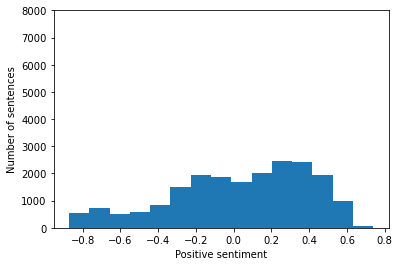

In [ ]:
plt.hist(df_bitcoin.apply(agg_score, axis=1),bins=15)
plt.ylim([0,8000])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of sentences')

In [ ]:
df_bitcoin['score']=df_bitcoin.apply(agg_score, axis=1)


In [ ]:
df_bitcoin.to_csv('/content/drive/MyDrive/Shared_ADA/M3/data/bitcoin_data_with_sentiment_final.csv',index=False)

We're now done with the sentiment computation, and we'll leverage these results to see if there's causality or only correlation between sentiment and greed index ...